# Act-seq
We adapted the procedure in Wu et al. 2017 to identify cells and ORs activated by a given odorant, by performing scRNA-seq on mice exposed to either odor ligands or the control solvent dipropylene glycol (DPG). OSN activation was read out via changes in immediate early gene (IEG) expression, ORs were considered activated based on the fraction of OSNs that expressed that OR that showed IEG induction. The effects of odor exposure were quantified for each OSN subtype by measuring changes in gene expression across a set of acutely-responsive activation genes, and these changes were summarized into a measure that were refer to as an activation score. 

In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import itertools
import numpy as np
import pandas as pd
import scanpy as sc

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cmocean

from osn.act import act
from osn.olfr import olfr
from osn.preprocess import get_data_folders
from osn.viz import viz

In [3]:
sns.set_context("notebook")
sns.set(font_scale=1.5, style="ticks", palette="tab10")

# load Act-seq data and get activated ORs for ACE/OCT

See docstrings for thresholds for functions. e.g. `help(act.apply_activation_score)`

In [4]:
data_fold = get_data_folders()
ad_fn = data_fold.processed / "ActSeq_norm.h5ad"

ACETO = "ACE2h"
OCT = "OCT2h"
DPG = "DPG30m"
odors=[ACETO, OCT]
color_dict = {DPG: plt.cm.tab10(0), ACETO: plt.cm.tab10(2), OCT: plt.cm.Set1(0)}

eA = "envA"
eB = "envB"
HC = "home-cage"
ENVS = [HC, eA, eB]
n_env = len(ENVS)

In [5]:
adata = sc.read(ad_fn)
print(adata)

AnnData object with n_obs × n_vars = 50781 × 27878
    obs: 'top_Olfr', 'orig_ident', 'source', 'odor', 'time', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_high_expr', 'log1p_total_counts_high_expr', 'pct_counts_high_expr', 'good_total_counts'
    var: 'mito', 'ribo', 'high_expr', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'X_nmf'


In [6]:
df_OR, has_OR = olfr.get_OR_info(adata)
df_OR.source.value_counts().sort_index()

DPG1           5050
DPG2           5805
v3-ACE2h-1     6385
v3-ACE2h-2     5084
v3-DPG30m-1    7238
v3-DPG30m-2    8152
v3-OCT2h-1     6980
v3-OCT2h-2     6087
Name: source, dtype: int64

In [7]:
act.apply_activation_score(adata)
odor_dict = act.get_activated_olfrs(adata, df_OR, odors=odors)
# example ORs with high activation scores
col_show = ["activated", "activation_score", "ieg_z_scored"]
for k, v in odor_dict.items():
    print(k)
    display(v["delta"][col_show].nlargest(10, "activation_score"))

Found 94 ORs (13.110 %) for ACE2h
Found 91 ORs (12.101 %) for OCT2h
ACE2h


,activated,activation_score,ieg_z_scored
top_Olfr,,,
Olfr876,1.000000,18.157852,2.869828
Olfr145,0.962963,16.819367,3.277435
Olfr1025-ps1,0.978723,16.279054,1.985459
Olfr874,1.000000,15.411139,1.498021
Olfr143,1.000000,15.279564,2.191252
Olfr744,1.000000,15.168688,1.896318
Olfr62,1.000000,15.027367,2.223002
Olfr160,1.000000,14.478305,2.896585
Olfr1026,1.000000,14.432154,1.463793


OCT2h


,activated,activation_score,ieg_z_scored
top_Olfr,,,
Olfr847,0.875000,20.604373,2.075966
Olfr218,0.941176,20.055757,1.867669
Olfr1170,1.000000,17.888338,1.972762
Olfr1167,1.000000,16.946386,1.337021
Olfr141,1.000000,16.263084,2.415233
Olfr716,1.000000,15.870116,1.782580
Olfr1408,0.937500,15.784118,1.289809
Olfr1155,1.000000,15.182191,1.752223
Olfr1404,0.944444,14.633869,1.538348


# plot Act-seq results

## IEG induction is specific to a subset of activated ORs, and only in odor-exposed mice

Text(0, 0.5, 'IEG score')

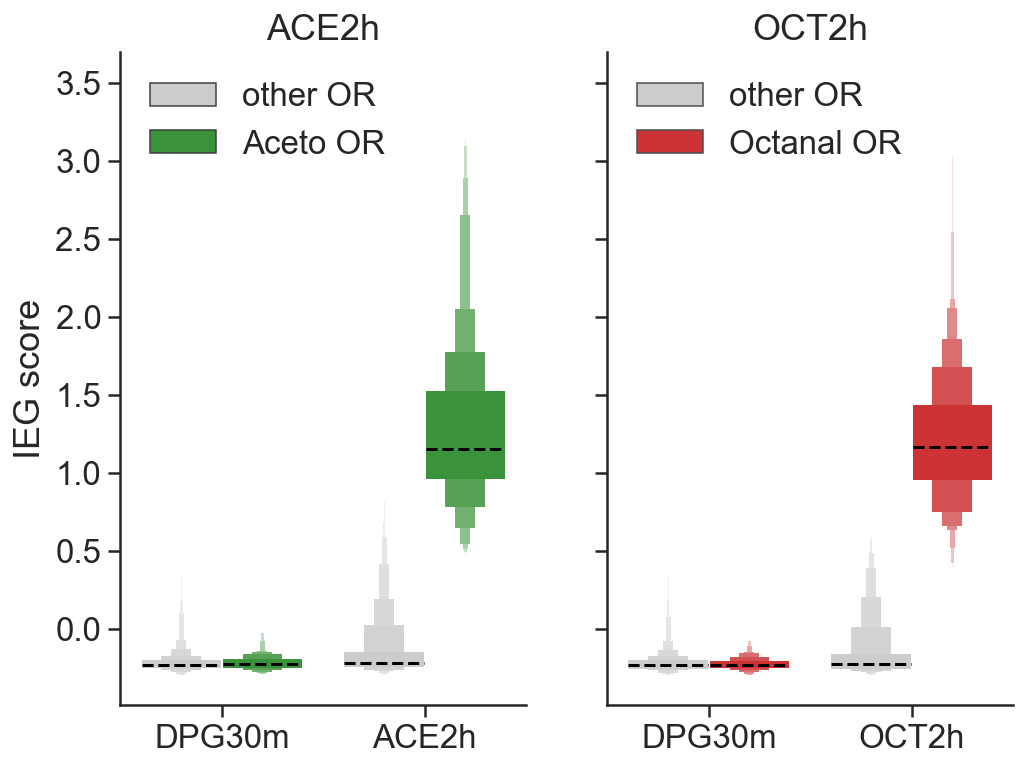

In [8]:
odor_mapping = {OCT: "Octanal OR", ACETO: "Aceto OR"}

fig, axes = plt.subplots(1, 2, figsize=(8, 6), sharey=True)

for ax, _odor in zip(axes, odors):
    this_dict = odor_dict[_odor]
    is_active = this_dict["active"]
    df_mean = this_dict["df"].reset_index()
    names = ["other OR",  odor_mapping[_odor]]
    df_mean['active'] = df_mean.is_active.map(dict(zip([False, True], names)))
    sns.boxenplot(
        data=df_mean,
        x="odor",
        y="ieg_z_scored",
        hue="active",
        ax=ax,
        order=(DPG, _odor),
        palette = ["0.8", color_dict[_odor]],
        hue_order=names,
        k_depth="proportion"
    )
    viz.update_boxen(ax)
    ax.set_title(_odor)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.legend(frameon=False)
sns.despine()
axes[0].set_ylabel("IEG score")

## plot ES score vs activation score 

Text(0, 0.5, 'Activation score')

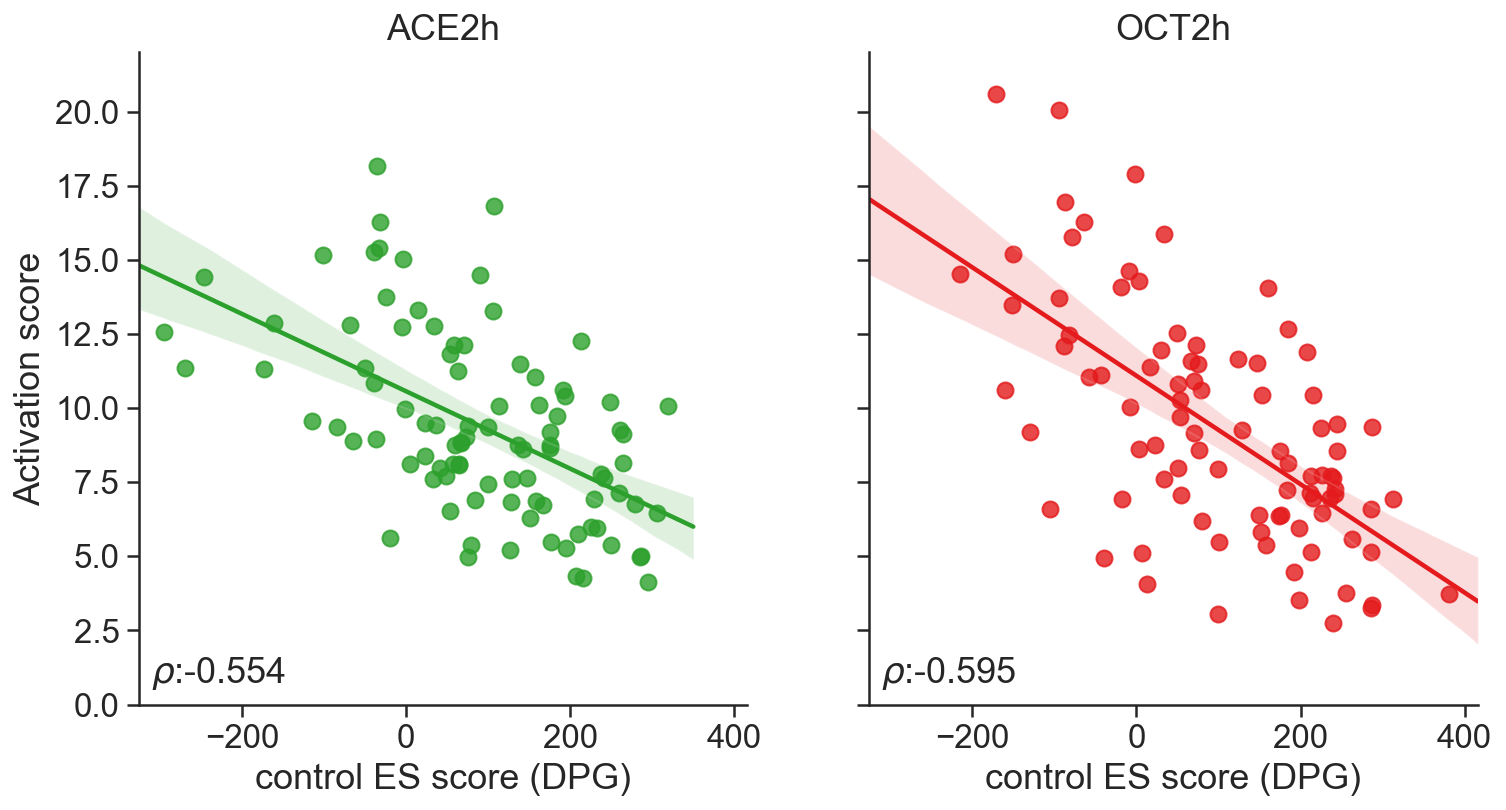

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True, sharex=True)

for ax, (_odor, this_dict) in zip(axes, odor_dict.items()):
    is_active = this_dict["active"]
    x = this_dict["df"]["ES_score"].loc[DPG]
    y = this_dict["delta"]["activation_score"]

    sns.regplot(
        x=x[is_active],
        y=y[is_active],
        color=color_dict[_odor],
        ax=ax,
        truncate=False,
        scatter_kws={"s": 64},
    )
    viz.plot_r(ax, x[is_active], y[is_active], r_loc=(0.02, 0.02), ha="left")
    ax.set_ylabel(None)
    ax.set_xlabel("control ES score (DPG)")
    ax.set_ylim(0, 22)
    ax.set_title(_odor)

sns.despine()
axes[0].set_ylabel("Activation score")

# Look at activation in environment switch experiments 

In [10]:
ad_fn = data_fold.processed / "env_switch_norm.h5ad"
adata = sc.read(ad_fn)
act.apply_activation_score(adata, platform="v3.1")
print(adata)

AnnData object with n_obs × n_vars = 94569 × 31756
    obs: 'top_Olfr', 'orig_ident', 'source', 'env', 'odor', 'time', 'ES_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_high_expr', 'log1p_total_counts_high_expr', 'pct_counts_high_expr', 'good_total_counts', 'n_ieg', 'ieg_z_scored', 'activated', 'activation_pca'
    var: 'mito', 'ribo', 'high_expr', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'X_nmf'


In [11]:
df_OR, has_OR = olfr.get_OR_info(adata)
display(df_OR.groupby(["env"]).odor.value_counts().unstack())

odor,ACE2h,DPG2h,DPG30m
env,,,
envA,11184,10092,10435
envB,12650,7346,11304
home-cage,11674,9489,10395


In [12]:
# get ORs activated in each env for ACE
env_odor_dict = {}
for e in ENVS:
    print(e)
    df_env = df_OR[df_OR.env == e]
    env_odor_dict[e] = act.get_activated_olfrs(adata, df_env, odors=[ACETO])[ACETO]

home-cage
Found 119 ORs (18.507 %) for ACE2h
envA
Found 133 ORs (19.559 %) for ACE2h
envB
Found 103 ORs (14.610 %) for ACE2h


## compare activation between each pair of envs 

In [13]:
env_combos = list(itertools.combinations(ENVS, 2))
pair_dict = {}
for combo in env_combos:
    print(combo)
    e1, e2 = combo
    # ACE OR in both envs
    both_active = (
        pd.concat({e: env_odor_dict[e]["active"] for e in combo}).unstack().sum(0) == 2
    )
    via_ieg = both_active.index[both_active]
    
    # ORs activation in both envs
    df_dpg_ace_keep = df_OR[
        (df_OR.odor.isin([ACETO, DPG]))
        & (df_OR.env.isin(combo))
        & (df_OR.top_Olfr.isin(via_ieg))
    ]
    df_dpg_ace_keep_mean = df_dpg_ace_keep.groupby(["odor", "env", "top_Olfr"]).mean()
    
    # change in ES scores across envs
    dpg_basal = df_dpg_ace_keep_mean.loc[DPG][["ES_score"]]
    delta_es = dpg_basal.loc[e2] - dpg_basal.loc[e1]
    
    # change in activation score across envs
    df_ace_delta = (
        df_dpg_ace_keep_mean.loc[ACETO]["activation_pca"]
        - df_dpg_ace_keep_mean.loc[DPG]["activation_pca"]
    )
    delta_act = df_ace_delta.loc[e2] - df_ace_delta.loc[e1]
    delta_act.name = "activation_score"
    pair_dict[combo] = delta_es.join(delta_act)
df_delta = pd.concat(pair_dict)

('home-cage', 'envA')
('home-cage', 'envB')
('envA', 'envB')


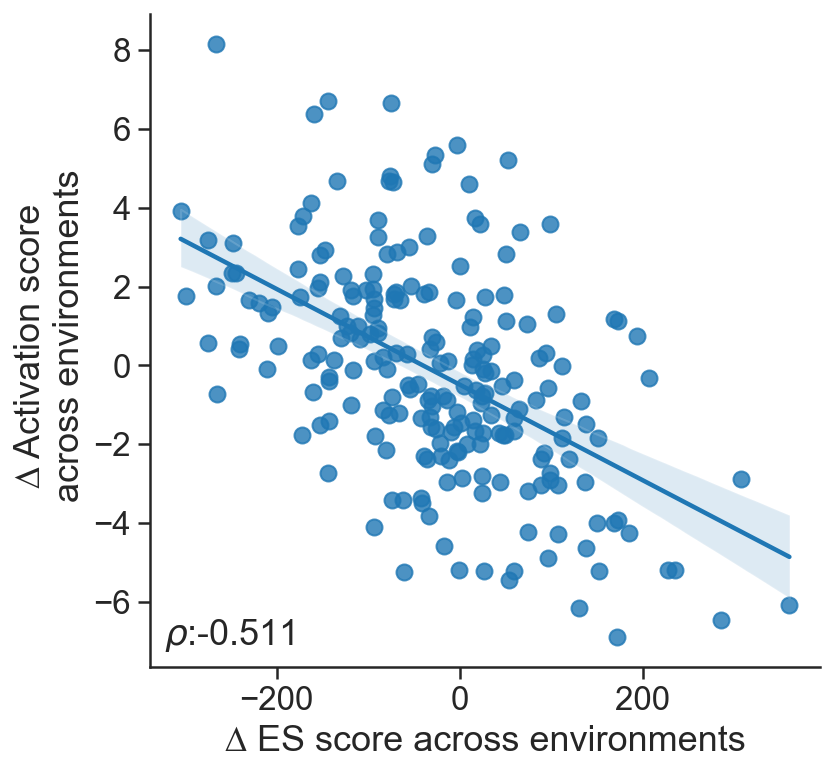

In [14]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.regplot(data=df_delta, x="ES_score", y="activation_score", scatter_kws={"s": 64})
ax.set_xlabel("∆ ES score across environments")
ax.set_ylabel("∆ Activation score \n across environments")
viz.plot_r(
    ax, df_delta.ES_score, df_delta.activation_score, r_loc=(0.02, 0.02), ha="left"
)
sns.despine()

# Activation for the ACE concentration series
* two-hour exposure to 0.01%, 0.1%, 1% and 10% ACE

## load data and get activation scores

In [15]:
ACE1p = "ACE1p"
ACE01p = "ACE0_1p"
ACE001p = "ACE0_01p"
ACES = [ACETO, ACE1p, ACE01p, ACE001p]
ACE_REV = ACES[::-1]
conc_cls = [cmocean.cm.haline(c) for c in [216, 180, 144, 96]]

new_concs = ['0.01%', '0.1%', '1%', '10%']
conc_labs = [l.rstrip("%") for l in new_concs]
conc_map = dict(zip(ACE_REV, new_concs))

In [16]:
ad_fn = data_fold.processed / "ActSeq_conc_analog_norm.h5ad"
adata_act = sc.read(ad_fn)
act.apply_activation_score(adata_act, platform="v3.1")
adata_keep = adata[
    (adata.obs.env == "home-cage") & (adata.obs.odor.isin((DPG, ACETO)))
].copy()
adata_act = adata_act.concatenate(adata_keep, index_unique=None, join="outer")
print(adata_act)

AnnData object with n_obs × n_vars = 141116 × 34474
    obs: 'top_Olfr', 'orig_ident', 'source', 'odor', 'time', 'conc', 'env', 'concentration (%)', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_high_expr', 'log1p_total_counts_high_expr', 'pct_counts_high_expr', 'good_total_counts', 'n_ieg', 'ieg_z_scored', 'activated', 'activation_pca', 'ES_score', 'OR_counts', 'OR_counts_norm', 'batch'
    var: 'mito-0', 'ribo-0', 'high_expr-0', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'mito-1', 'ribo-1', 'high_expr-1', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_tota

In [17]:
df_OR, has_OR = olfr.get_OR_info(adata_act)
ace_dict = act.get_activated_olfrs(adata_act, df_OR, odors=ACES, exclude_dpg_olfr=True)

# activation score for ACE ORs activated at 10%
ace_olfr = ace_dict[ACETO]["via_ieg"]
df_act_mean = df_OR.groupby(["odor", "top_Olfr"]).mean()
df_act_delta = df_act_mean - df_act_mean.loc[DPG]
df_active = pd.concat({o: ace_dict[o]["active"] * 100 for o in ACES}).reset_index()
ieg_all = df_act_mean.loc[ACES]["activated"].unstack().T
df_activation_score = (
    df_act_delta.loc[ACES]["activation_pca"].unstack().T.loc[ace_olfr].melt()
)

Found 136 ORs (19.155 %) for ACE2h
Found 42 ORs (5.556 %) for ACE1p
Found 15 ORs (1.775 %) for ACE0_1p
Found 8 ORs (1.064 %) for ACE0_01p


## Plot % of ORs activated at each concentration 

Text(0.5, 0, 'ACE (%)')

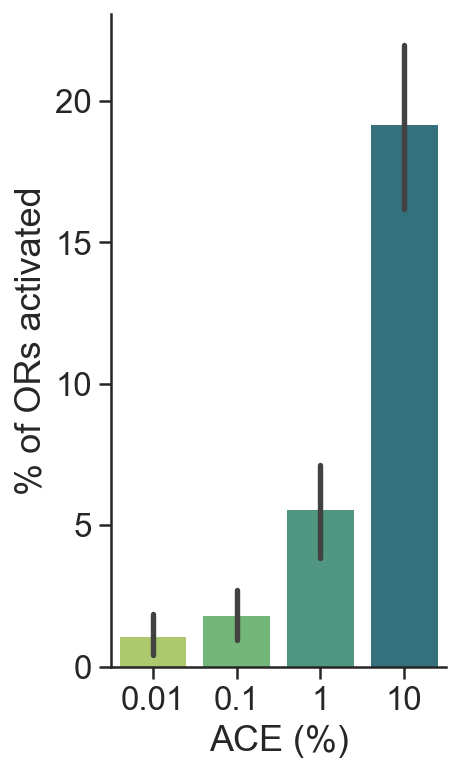

In [18]:
fig, ax = plt.subplots(figsize=(3, 6))
sns.barplot(
    data=df_active,
    y=0,
    x="level_0",
    lw=0,
    order=ACE_REV,
    palette=conc_cls,
)
ax.set_xticklabels(conc_labs)
sns.despine()
ax.set_ylabel("% of ORs activated")
ax.set_xlabel("ACE (%)")

## % cells activated per OR, using ORs activated by 10%

(132, 4)


Text(0.5, 0, 'ACE (%)')

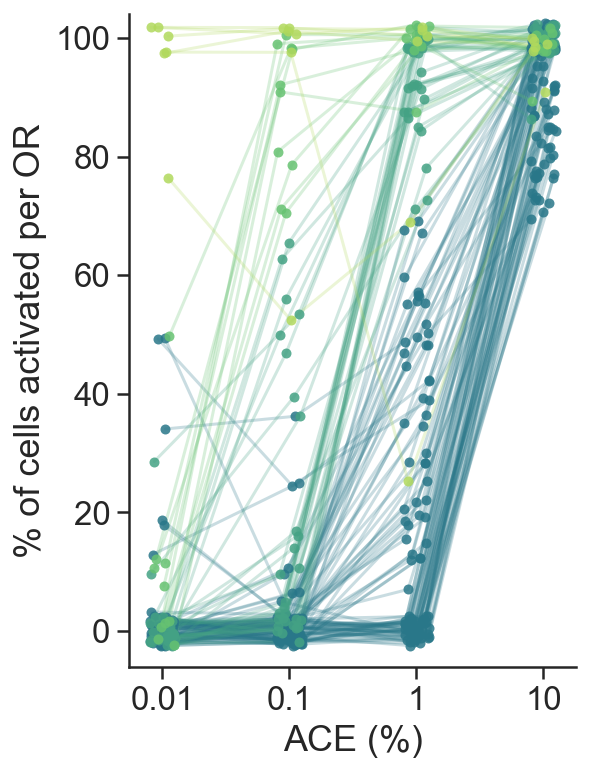

In [19]:
n_ace = len(ACES)
ieg = ieg_all.loc[ace_olfr]
ieg = ieg[~ieg.isna().any(1)]
print(ieg.shape)
i_max = ((ieg[ACE_REV] >= 0.7).values).argmax(1)
color_list = [conc_cls[i] for i in i_max]

np.random.seed(1234)
_x = np.zeros_like(ieg[list(ACE_REV)].T) + np.arange(n_ace)[:, np.newaxis]
_x += (np.random.rand(*_x.shape) - 0.5) / 5
_y = ieg[list(ACE_REV)].T.values
_y += (np.random.rand(*_y.shape) - 0.5) / 20
_y = _y * 100


fig, ax = plt.subplots(figsize=(4, 6))
ax.set_prop_cycle(color=color_list)

for i in np.unique(i_max)[::-1]:

    is_i = i_max == i

    ax.plot(_x[:, is_i], _y[:, is_i], color=conc_cls[i], alpha=0.25, zorder=-5)
    ax.scatter(
        _x[:, is_i], _y[:, is_i], color=conc_cls[i], alpha=0.85, lw=0, s=25, zorder=10
    )

sns.despine()
ax.set_xticks(np.arange(n_ace))
ax.set_ylabel("% of cells activated per OR")

ax.set_xticklabels(conc_labs)
ax.set_ylim(-6, 104)

sns.despine()
ax.set_xlabel("ACE (%)")

## Activation score for each OSN subtype at each conc., using ORs activated by 10% 

(-4.2, 17.511501868502535)

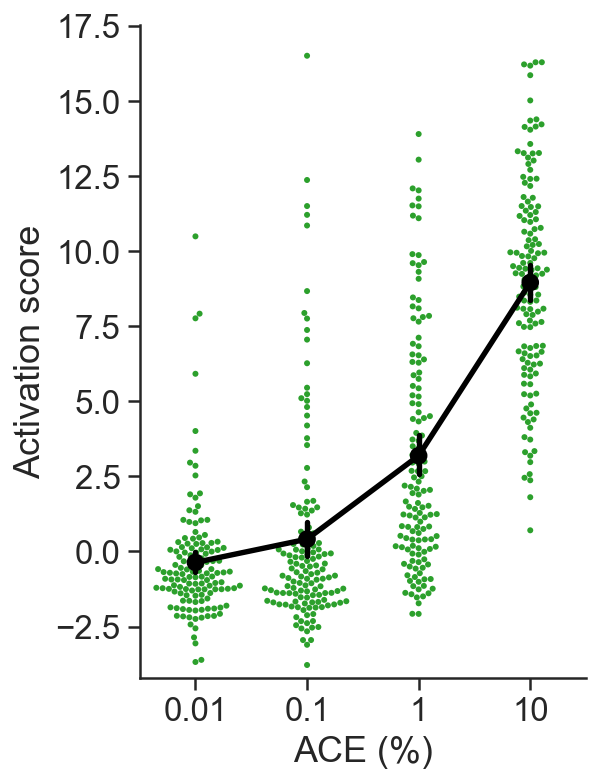

In [20]:
fig, ax = plt.subplots(figsize=(4, 6))
sns.swarmplot(
    data=df_activation_score,
    x="odor",
    y="value",
    color=color_dict[ACETO],
    zorder=-5,
    linewidth=0,
    edgecolor="0.5",
    order=ACE_REV,
    size=3,
)
sns.pointplot(
    data=df_activation_score, x="odor", y="value", color="k", zorder=5, order=ACE_REV
)
sns.despine()
ax.set_xticklabels(conc_labs)
ax.set_xlabel("ACE (%)")
ax.set_ylabel("Activation score")
ax.set_ylim(-4.2, None)

# Activation for the ACE analogs
* Two-hour exposure to either ACE, 2-HA or two other related odorants

In [21]:
ANALOGS = [ACETO, "2HA2h", "4MA2h", "MS2h"]
ODOR_NAMES = [o.rstrip("2h") for o in ANALOGS]
analog_cls = [plt.cm.Set1(2)] + ["#a76abf", "#53bcff", "#f48074"]

analog_dict = act.get_activated_olfrs(adata_act, df_OR, odors=ANALOGS, exclude_dpg_olfr=True)

Found 136 ORs (19.155 %) for ACE2h
Found 23 ORs (3.814 %) for 2HA2h
Found 45 ORs (5.929 %) for 4MA2h
Found 66 ORs (8.240 %) for MS2h


Text(20.1, 0.5, 'Odor$_B$')

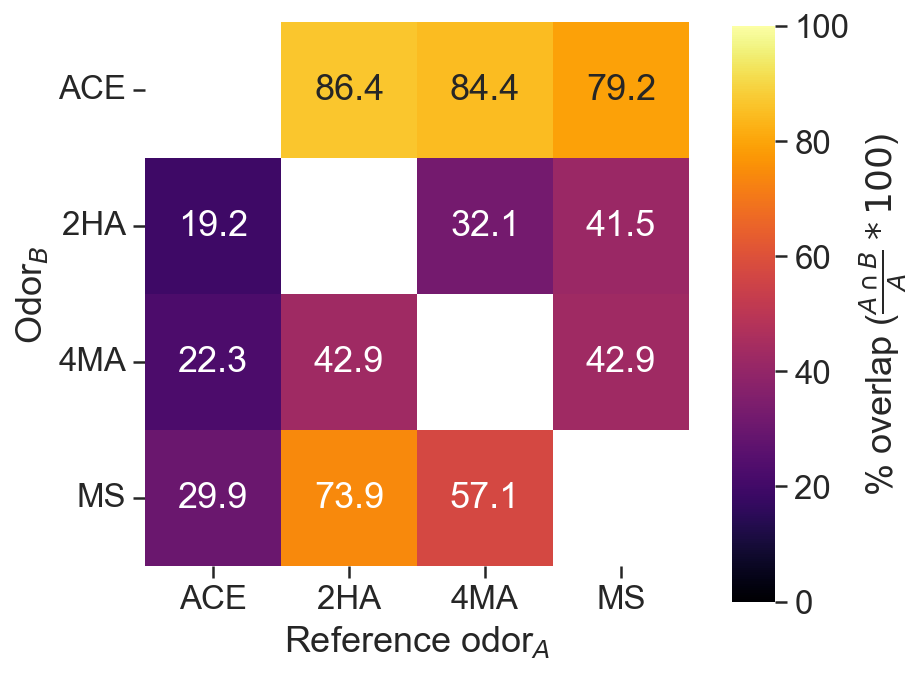

In [22]:
# overlap in the set of activated ORs for each pair of analogs
active_dict = {o: analog_dict[o]["active"] for o in ANALOGS}
df_analog = pd.concat(active_dict).unstack().T
# pairwise intersection
n_odors = len(ANALOGS)
sums = np.zeros((n_odors, n_odors))
for i, o1 in enumerate(ANALOGS):
    x = df_analog[o1]
    x = x[~x.isna()]
    x = x[x]
    for j, o2 in enumerate(ANALOGS):
        y = df_analog[o2]
        y = y[~y.isna()]
        in_both = x.index.intersection(y.index)
        sums[i, j] = y.loc[in_both].mean()
np.fill_diagonal(sums, np.nan)
df_overlap = pd.DataFrame(sums * 100, index=ODOR_NAMES, columns=ODOR_NAMES)

fig, ax = plt.subplots(figsize=(5, 5))
cax = fig.add_axes([0.95, 0.075, 0.06, 0.8])
sns.heatmap(
    df_overlap.T,
    ax=ax,
    square=True,
    cbar_ax=cax,
    cmap="inferno",
    vmin=0,
    vmax=100,
    annot=True,
    fmt=".3g",
    cbar_kws={"label": r"% overlap ($\frac{A \cap B}{A} * 100$)"},
)
ax.set_yticklabels(ODOR_NAMES, rotation=0)
ax.set_xlabel(r"Reference odor$_A$")
ax.set_ylabel("Odor$_B$")

Text(0.5, 0, 'Odor')

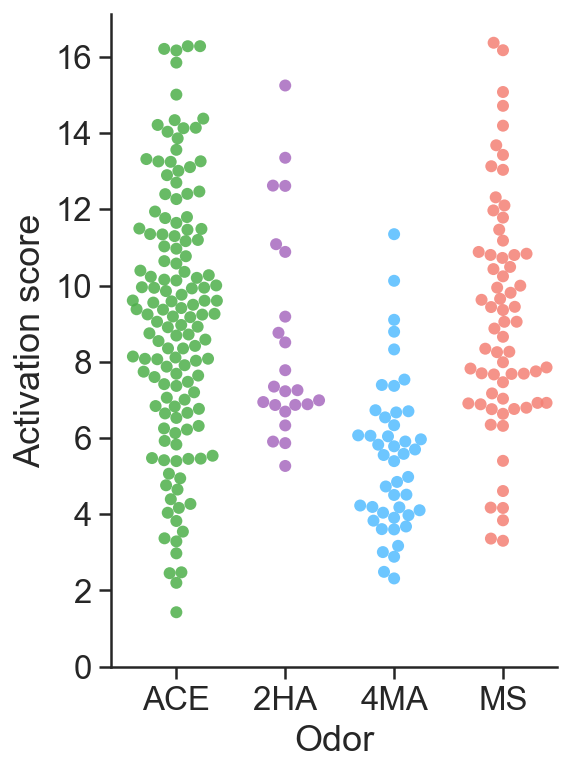

In [23]:
# activation score for each analog
score_dict = {}
for o, this_dict in analog_dict.items():
    is_active = this_dict["active"]
    score_dict[o] = this_dict["delta"]["activation_pca"][is_active]
df_score = pd.concat(score_dict).reset_index()

fig, ax = plt.subplots(figsize=(4,6))
sns.swarmplot(
    data=df_score,
    y="activation_pca",
    x="level_0",
    order=ANALOGS,
    palette=analog_cls,
    ax=ax,
    size=6,
    zorder=-5,
    linewidth=0,
    edgecolor="0.5",
    alpha=0.85,
)
ax.set_xlim(-0.6, None)
ax.set_ylim(0, None)
ax.set_xticklabels(ODOR_NAMES)
sns.despine()
ax.set_ylabel("Activation score")
ax.set_xlabel("Odor")

## plot activation score of example ORs for low concentrations of ACE/2-HA

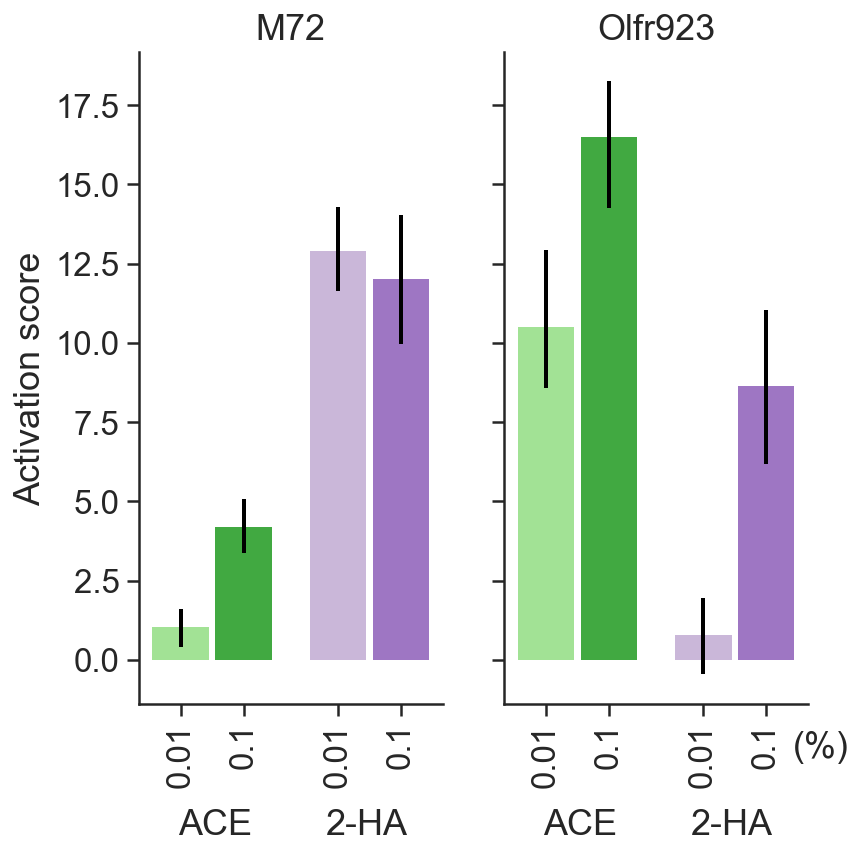

In [24]:
fig, axes = viz.ace_2ha_activation_score(
    df_OR, example_olfr=("Olfr160", "Olfr923"), names=("M72", "Olfr923")
)